![alt text](https://engmrk.com/wp-content/uploads/2018/09/LeNet_Original_Image.jpg)

![alt text](https://engmrk.com/wp-content/uploads/2018/09/LeNEt_Summary_Table.jpg)

In [1]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
import torchvision.datasets

In [3]:
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)


|          | 0/? [00:00<?, ?it/s]

Extracting ./MNIST\raw\train-images-idx3-ubyte.gz to ./MNIST\raw


|          | 0/? [00:00<?, ?it/s]

Extracting ./MNIST\raw\train-labels-idx1-ubyte.gz to ./MNIST\raw


|          | 0/? [00:00<?, ?it/s]

Extracting ./MNIST\raw\t10k-images-idx3-ubyte.gz to ./MNIST\raw


|          | 0/? [00:00<?, ?it/s]

Extracting ./MNIST\raw\t10k-labels-idx1-ubyte.gz to ./MNIST\raw
Processing...
Done!


M:\Users\user\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\datasets\mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

M:\Users\user\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\datasets\mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
M:\Users\user\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\datasets\mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
M:\Users\user\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\datasets\mnist.py:63: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
M:\Users\user\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\datasets\mnist.py:53: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [7]:
X_train.shape

torch.Size([60000, 28, 28])

In [38]:
len(y_train), len(y_test)

(60000, 10000)

TypeError: Invalid shape (1, 28, 28) for image data

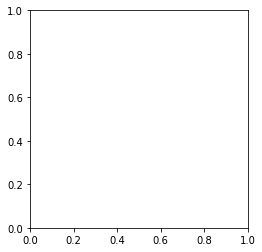

In [37]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [9]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [48]:
X_train.shape

torch.Size([60000, 1, 28, 28])

In [11]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
       
        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.Tanh()
        
        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.Tanh()
        
        self.fc3   = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x
    
lenet5 = LeNet5()

In [41]:
np.eye(1, 10, k=2, dtype=np.float32).reshape(-1)

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = lenet5.to(device)

In [13]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)

In [14]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(5):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = lenet5.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    test_preds = lenet5.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).data.cpu())
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)
    
    print(accuracy)

tensor(0.9759)
tensor(0.9824)
tensor(0.9851)
tensor(0.9879)
tensor(0.9870)
tensor(0.9874)
tensor(0.9878)


KeyboardInterrupt: 

In [63]:
lenet5.forward(X_test[0].unsqueeze(0)).argmax(dim=1).item()

7

In [76]:
def conv_output_shape(h_w, kernel_size=1, stride=1, pad=0, dilation=1):
    """
    Utility function for computing output of convolutions
    takes a tuple of (h,w) and returns a tuple of (h,w)
    """
    
    if type(h_w) is not tuple:
        h_w = (h_w, h_w)
    
    if type(kernel_size) is not tuple:
        kernel_size = (kernel_size, kernel_size)
    
    if type(stride) is not tuple:
        stride = (stride, stride)
    
    if type(pad) is not tuple:
        pad = (pad, pad)
    
    h = (h_w[0] + (2 * pad[0]) - (dilation * (kernel_size[0] - 1)) - 1)// stride[0] + 1
    w = (h_w[1] + (2 * pad[1]) - (dilation * (kernel_size[1] - 1)) - 1)// stride[1] + 1
    
    return h, w

In [77]:
conv_output_shape(28, )

(28, 28)

In [71]:
torch.nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2)(X_test).shape

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [55]:
X_test[round(10 * 0.9):].shape

torch.Size([9991, 1, 28, 28])

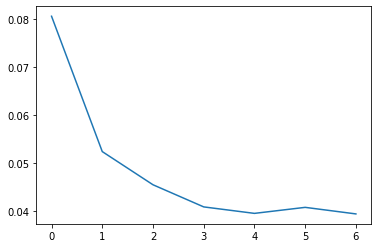

In [16]:
# plt.plot(test_accuracy_history);
plt.plot(test_loss_history);